In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.preprocessing import scale
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import load_model
from keras import metrics
from keras.regularizers import l2
import models.nnmodels as nn
import utils.data as data

import gc
gc.enable()
seed = 0
np.random.seed(seed)
%matplotlib inline

Using TensorFlow backend.


In [2]:
print 'Loading DEAP dataset...'
subject_data_folds, valence_folds, arousal_folds = data.load_deap(32, 2)
print 'DEAP dataset is loaded.\n'

print 5*'#' + ' Dataset representation for each subject ' + 5*'#'
print '\nThere are {} subjects in the dataset.\n'.format(len(subject_data_folds))
print '(Trail/Video, Channel, Readings) : ', subject_data_folds[0].shape
print '(Trail/Video, label (valence or arousal)) : ', arousal_folds[0].shape

Loading DEAP dataset...
DEAP dataset is loaded.

##### Dataset representation for each subject #####

There are 32 subjects in the dataset.

(Trail/Video, Channel, Readings) :  (40, 40, 8064)
(Trail/Video, label (valence or arousal)) :  (40, 2)


In [3]:
# Select last 30 seconds of only EGG channels
subject_egg_data_folds = []
for s in subject_data_folds:
    subject_egg_data_folds.append(s[:,:,4032:-2])
    
# Check the shape
subject_egg_data_folds[0].shape

(40, 40, 4030)

In [4]:
# Create a boolean mask to select specific channels
# mask to select channels 1, 2, 4, 5, 8, 10, 15, 21, 22, 25, 26, 27, 28, 31, 32
mask = [True, True, False, True, True, False, False, True, False, True, False, False, False, False, True, \
       False, False, False, False, False, True, True, False, False, True, True, True, True, False, False, \
       True, True, False, False, False, False, False, False, False, False]

subject_selected_egg_folds = []
for s in subject_egg_data_folds:
    subject_selected_egg_folds.append(s[:,mask,:])

# Check the shape
subject_selected_egg_folds[0].shape

(40, 15, 4030)

In [6]:

# Split each sample into 10 sample (400 experiment per subject) 

X = np.concatenate(subject_selected_egg_folds, axis=0)
print  X.shape
X_reshaped=X.reshape(X.shape[0], X.shape[1]*X.shape[2])
print X_reshaped.shape
X_reshaped_norm = scale(X_reshaped)
X_norm = X_reshaped_norm.reshape(X.shape[0], X.shape[1],X.shape[2])
print  X_norm.shape
my_egg_data = []
for egg_fold in subject_selected_egg_folds:
    
    subject_splited = np.split(egg_fold, 10, axis=-1)
    augmented_subject = np.concatenate(subject_splited)
    
    my_egg_data.append(augmented_subject)



(1280, 15, 4030)
(1280, 60450)
(1280, 15, 4030)


In [7]:
# Repeat the labels for experiments

new_valence_folds = []
for l in valence_folds:
    new_l = l.repeat(10, axis=0)
    new_valence_folds.append(new_l)


In [8]:
my_egg_data[0].shape

(400, 15, 403)

In [9]:
from scipy.signal import periodogram
import numpy as np
from scipy.stats import skew, kurtosis

def psd(data):
    
    
        def summerize(sub_band):
            
            exp, ch, r = sub_band.shape
            
            sub_band_summerized = np.sum(np.square(sub_band), axis=-1, keepdims=True)
            """
            # Mean of the sub band
            sub_band_summerized = sub_band.mean(axis=-1, keepdims=True)
            
            # Median of the sub band
            sub_band_summerized = np.append(sub_band_summerized, np.median(sub_band, axis=-1, keepdims=True), axis=-1)
            
            # Maximum of the sub band
            sub_band_summerized = np.append(sub_band_summerized, np.amax(sub_band, axis=-1, keepdims=True), axis=-1)
            
            # Minimum of the sub band
            sub_band_summerized = np.append(sub_band_summerized, np.amin(sub_band, axis=-1, keepdims=True), axis=-1)
            
            # Std of the sub band
            sub_band_summerized = np.append(sub_band_summerized, np.std(sub_band, axis=-1, keepdims=True), axis=-1)
            
            # Variance of the sub band
            sub_band_summerized = np.append(sub_band_summerized, np.var(sub_band, axis=-1, keepdims=True), axis=-1)
            
            # Range of the sub band
            _range = np.ptp(sub_band, axis=-1)
            _range = _range.reshape(exp,ch,1)
            sub_band_summerized=np.append(sub_band_summerized, _range, axis=-1)
            
            # Skewness of the sub band
            _skew = skew(sub_band, axis=-1)
            _skew = _skew.reshape(exp,ch,1)
            sub_band_summerized=np.append(sub_band_summerized, _range, axis=-1)
            
            # Kurtosis of the sub band
            _kurtosis= kurtosis(sub_band, axis=-1)
            _kurtosis = _kurtosis.reshape(exp,ch,1)
            sub_band_summerized=np.append(sub_band_summerized, _range, axis=-1)
            """
            return sub_band_summerized
        
        sub_band_list = []
        # Theta band 4-7Hz
        _, theta4 = periodogram(data, fs=4.0, window='hann', axis=-1)
        _, theta5 = periodogram(data, fs=5.0, window='hann', axis=-1)
        _, theta6 = periodogram(data, fs=6.0, window='hann', axis=-1)
        _, theta7 = periodogram(data, fs=7.0, window='hann', axis=-1)
        
        sub_band_list.append(theta4)
        sub_band_list.append(theta5)
        sub_band_list.append(theta6)
        sub_band_list.append(theta7)
        
        # Alpha band 8-12Hz
        _, alpha8 = periodogram(data, fs=8.0, window='hann', axis=-1)
        _, alpha9 = periodogram(data, fs=9.0, window='hann', axis=-1)
        _, alpha11 = periodogram(data, fs=11.0, window='hann', axis=-1)
        _, alpha12 = periodogram(data, fs=12.0, window='hann', axis=-1)
        
        
        sub_band_list.append(alpha8)
        sub_band_list.append(alpha9)
        sub_band_list.append(alpha11)
        sub_band_list.append(alpha12)
        
        # Lower Beta band 13-21Hz
        _, lBetha13 = periodogram(data, fs=13.0, window='hann', axis=-1)
        _, lBetha16 = periodogram(data, fs=16.0, window='hann', axis=-1)
        _, lBetha19 = periodogram(data, fs=19.0, window='hann', axis=-1)
        _, lBetha21 = periodogram(data, fs=21.0, window='hann', axis=-1)
        
        sub_band_list.append(lBetha13)
        sub_band_list.append(lBetha16)
        sub_band_list.append(lBetha19)
        sub_band_list.append(lBetha21)
        
        
        # Upper Beta band 22-30Hz
        _, uBetha22 = periodogram(data, fs=22.0, window='hann', axis=-1)
        _, uBetha24 = periodogram(data, fs=24.0, window='hann', axis=-1)
        _, uBetha27 = periodogram(data, fs=27.0, window='hann', axis=-1)
        _, uBetha30 = periodogram(data, fs=30.0, window='hann', axis=-1)
        
        sub_band_list.append(uBetha22)
        sub_band_list.append(uBetha24)
        sub_band_list.append(uBetha27)
        sub_band_list.append(uBetha30)
        
        # Gamma band 30-45Hz
        _, gamma32 = periodogram(data, fs=32.0, window='hann', axis=-1)
        _, gamma37 = periodogram(data, fs=37.0, window='hann', axis=-1)
        _, gamma41 = periodogram(data, fs=41.0, window='hann', axis=-1)
        _, gamma45 = periodogram(data, fs=45.0, window='hann', axis=-1)
        
        sub_band_list.append(gamma32)
        sub_band_list.append(gamma37)
        sub_band_list.append(gamma41)
        sub_band_list.append(gamma45)
        
        sub_band_list_summerized = []
        for sub_band in sub_band_list:
            sub_band_list_summerized.append(summerize(sub_band))
        data_summerized = np.concatenate(sub_band_list_summerized, axis=-1)
            
        return data_summerized 
    
    
    

In [10]:
train_data = []
for data in my_egg_data:
    train_data.append(psd(data))

In [11]:
train_data[0].shape

(400, 15, 20)

In [12]:


with open('train_data.pickle', 'wb') as handle:
    pickle.dump(train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('new_valence_folds.pickle', 'wb') as handle:
    pickle.dump(new_valence_folds, handle, protocol=pickle.HIGHEST_PROTOCOL)
    


In [13]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import load_model
from keras import metrics
from sklearn.preprocessing import scale
from keras.regularizers import l2
import models.nnmodels as nn
import utils.data as data

import gc
gc.enable()
seed = 0
np.random.seed(seed)
%matplotlib inline


with open('train_data.pickle', 'rb') as handle:
    train_data = pickle.load(handle)
    
with open('new_valence_folds.pickle', 'rb') as handle:
    new_valence_folds = pickle.load(handle)

In [14]:
print len(train_data)
print train_data[0].shape
print new_valence_folds[0].shape

32
(400, 15, 20)
(400, 2)


In [3]:
train_data = train_data_15ch

In [15]:
X_train = np.concatenate(train_data)
X_train.shape

(12800, 15, 20)

In [16]:
X_train = X_train.reshape(12800, 15*20)
X_norm = scale(X_train)

X_norm = X_norm.reshape(12800, 15, 20)

train_data = np.split(X_norm, 32)

print train_data[0][365,14,:]

[-0.06895836 -0.06895836 -0.06895836 -0.06895836 -0.06895836 -0.06895836
 -0.06895836 -0.06895836 -0.06895836 -0.06895836 -0.06895836 -0.06895836
 -0.06895836 -0.06895836 -0.06895836 -0.06895836 -0.06895836 -0.06895836
 -0.06895836 -0.06895836]


/home/omid/venv2/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


##### Two Classes Classification for Valence emotion Using Convolutional Neural Network #####

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 8, 1, 18)          368       
_________________________________________________________________
activation_13 (Activation)   (None, 8, 1, 18)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 1, 16)          304       
_________________________________________________________________
activation_14 (Activation)   (None, 8, 1, 16)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 1, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_______________________________________________

12400/12400 [==============================] - 1s 86us/step - loss: 0.6871 - categorical_accuracy: 0.5556 - val_loss: 0.7034 - val_categorical_accuracy: 0.4750
Epoch 32/50
12400/12400 [==============================] - 1s 87us/step - loss: 0.6871 - categorical_accuracy: 0.5556 - val_loss: 0.7027 - val_categorical_accuracy: 0.4750
Epoch 33/50
12400/12400 [==============================] - 1s 89us/step - loss: 0.6869 - categorical_accuracy: 0.5556 - val_loss: 0.7078 - val_categorical_accuracy: 0.4750
Epoch 34/50
12400/12400 [==============================] - 1s 91us/step - loss: 0.6871 - categorical_accuracy: 0.5556 - val_loss: 0.7065 - val_categorical_accuracy: 0.4750
Epoch 35/50
12400/12400 [==============================] - 1s 91us/step - loss: 0.6870 - categorical_accuracy: 0.5556 - val_loss: 0.7065 - val_categorical_accuracy: 0.4750
Epoch 36/50
12400/12400 [==============================] - 1s 92us/step - loss: 0.6872 - categorical_accuracy: 0.5556 - val_loss: 0.7056 - val_categoric

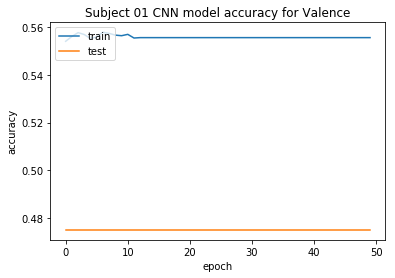

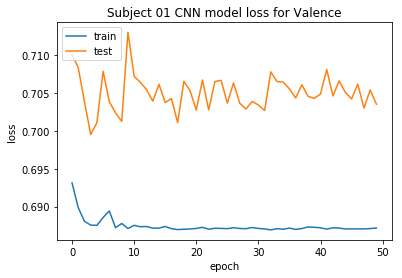

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 8, 1, 18)          368       
_________________________________________________________________
activation_17 (Activation)   (None, 8, 1, 18)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 1, 16)          304       
_________________________________________________________________
activation_18 (Activation)   (None, 8, 1, 16)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 1, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
__________

In [ ]:


num_subjects = 32
batch_size = 50
epochs = 50
num_exp = 40


accuracies = []

print '##### Two Classes Classification for Valence emotion Using Convolutional Neural Network #####\n'

num_subjects = 32

for s in np.arange(0, num_subjects):
    

    
    """
    X_val = reduced_data_folds[s]
    X_val = np.expand_dims(X_val, axis=1)
    y_val = valence_folds[s]
    
    X_remaining_folds = reduced_data_folds[:s]  + reduced_data_folds[s+1:]
    y_remaining_folds = valence_folds[:s] + valence_folds[s+1:]
    X_train = np.concatenate(X_remaining_folds)
    X_train = np.expand_dims(X_train, axis=1)  
    y_train = np.concatenate(y_remaining_folds)
    
    
    """
    start_time = time.time()
    
    X_val = train_data[s]
    X_val = np.expand_dims(X_val, axis=1)
    y_val = new_valence_folds[s]
    
    X_remaining_folds = train_data[:s]  + train_data[s+1:]
    y_remaining_folds = new_valence_folds[:s] + new_valence_folds[s+1:]
    X_train = np.concatenate(X_remaining_folds)
    X_train = np.expand_dims(X_train, axis=1)  
    y_train = np.concatenate(y_remaining_folds)

    model = nn.CnnNew(num_classes=2, emotion='valence', input_shape=X_train.shape[1:])



    key = 's'+str(s+1).zfill(2)+'_valence(3classes)'
    
    

    
    
# checkpoint
    filepath="../saved_models/best_Cnn1D_model_for_{}.h5".format(key)

    checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy',
                                verbose=1, save_best_only=True, mode='max', period=5)
    
    #tensorboard = TensorBoard(log_dir='../logs', histogram_freq=1, batch_size=50, write_graph=True, \
        #write_grads=True, write_images=True)
    
    callbacks_list = [checkpoint]#, tensorboard]    
    
       
    hist = model.fit(X_train, y_train, 
             batch_size=batch_size,
             epochs=epochs,
             shuffle=True,
             verbose=1,
             validation_data=(X_val, y_val), callbacks=callbacks_list)

    model.load_weights(filepath)
    
    #scores = model.evaluate(x=X_val, y=y_val)
    
    y_val_pred = model.predict(X_val, batch_size=50)
    
    accuracy = np.sum(y_val_pred==y_val)/(2*len(y_val))

    print '#### Result of CNN model for subject {} #####\n'.format(str(s+1).zfill(2))
    print "Accuracy : {}%".format( accuracy*100)
    
    print 'Training time: {}'.format(time.time() - start_time)


    accuracies.append(accuracy)
    # summarize history for accuracy
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Subject ' +str(s+1).zfill(2)+ ' CNN model accuracy for Valence')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Subject ' +str(s+1).zfill(2)+ ' CNN model loss for Valence')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [6]:
accuracy

0

In [ ]:
min_acc_subject_idx, max_acc_subject_idx = np.argmin(accuracies), np.argmax(accuracies)

avg_acc =  reduce(lambda x, y: x + y, accuracies) / len(accuracies)

print 5*'#' + ' Accuracies per subject ' + 5*'#'

print 'Subject {} has the minimum accuracy : {}%'.format(min_acc_subject_idx + 1, min(accuracies)*100)
print 'Subject {} has the maximum accuracy : {}%'.format(max_acc_subject_idx + 1, max(accuracies)*100)
print 'Average accuracy : {}%'.format(avg_acc*100)

for subj in enumerate(accuracies):
    print 'Accuracy of Subject {} : {}%'.format(subj[0]+1, subj[1]*100)